# **Inhomogeneous 1D wave equation (source)**:
# $ u_{tt} - 4u_{xx} = xt, \qquad 0 < x < \pi, \quad 0<t<1, \quad u = u(x,t)$

## 1. Boundary conditions (Dirichlet):
* $ u(0, t) = 0 \qquad 0 \leq t \leq 1$
* $ u(\pi, t) = \frac{\pi t^3}{6} \qquad 0 \leq t \leq 1$

## 2. Initial conditions:
* $ u(x, 0) = sin(2x) \qquad 0 \leq x \leq \pi$
* $ u_t(x, 0) = 8sin(2x) - 16sin(4x) \qquad 0 \leq x \leq \pi$

## *ANALYTICAL SOLUTION*
## $ u(x, t) = sin(2x) \left( cos(4t) + 2sin(4t) \right) - 2sin(4x)sin(8t) + \frac{xt^3}{6} $

# ====================== OR =========================

# $ u_{tt} - \frac{4}{\pi^2} u_{xx} = \pi xt, \qquad 0 < x < 1, \quad 0<t<1, \quad u = u(x,t)$

## 1. Boundary conditions (Dirichlet):
* $ u(0, t) = 0 \qquad 0 \leq t \leq 1$
* $ u(1, t) = \frac{\pi t^3}{6} \qquad 0 \leq t \leq 1$

## 2. Initial conditions:
* $ u(x, 0) = sin(2\pi x) \qquad 0 \leq x \leq 1$
* $ u_t(x, 0) = 8sin(2\pi x) - 16sin(4\pi x) \qquad 0 \leq x \leq 1$

## *ANALYTICAL SOLUTION*
## $ u(x, t) = sin(2\pi x) \left( cos(4t) + 2sin(4t) \right) - 2sin(4\pi x)sin(8t) + \frac{\pi xt^3}{6} $

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader
from scipy.stats import qmc
from scipy.io import loadmat

# Helpers

## Plots

In [17]:
def plot3D(x,t,y):
  # x_plot =x.squeeze(1)
  # t_plot =t.squeeze(1)
  # X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  # cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

## PINN

In [18]:
class FeedForward(nn.Module):
  def __init__(self,
               layers,
               activation=nn.ReLU(),
               weight_init=None,
               bias_init=None,
               device='cpu'):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers).to(device)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

In [19]:
class Data():
  def __init__(self,
               x_min, x_max,
               t_min, t_max,
               Nc, N_IC, Nl_BC, Nr_BC,
               Nx_test, Nt_test,
               device='cpu',
               dtype=torch.float32,
               EPS=1e-5):

    super().__init__()
    self.x_min = x_min
    self.x_max = x_max
    self.t_min = t_min
    self.t_max = t_max
    self.Nc = Nc
    self.N_IC = N_IC
    self.Nl_BC = Nl_BC
    self.Nr_BC = Nr_BC
    self.Nx_test = Nx_test
    self.Nt_test = Nt_test
    self.device = device
    self.dtype = dtype
    self.EPS = EPS

  # ============================= TRAINING DATA ==============================

  # *** Create collocation points ***
  def sample_inside(self, Nc, x_min, x_max, t_min, t_max):
    # Random Grid
    XT_c = qmc.scale(qmc.LatinHypercube(2).random(Nc),
                      [x_min + self.EPS, t_min + self.EPS],
                      [x_max - self.EPS, t_max - self.EPS])
    return torch.tensor(XT_c, dtype=self.dtype, device=self.device)

  # *** Initial condition (t=0) ***
  # 1. u(x,0) = sin(2πx)
  # 2. u_t(x,0) = 8*sin(2πx) - 16*sin(4πx)
  def sample_initial(self, N_IC, x_min, x_max):
    x_IC = np.linspace(x_min, x_max, N_IC).reshape(-1, 1)
    t_IC = np.zeros((N_IC, 1))

    XT_IC = np.concatenate((x_IC, t_IC), axis=1)
    u_IC = np.sin(2*np.pi*x_IC)
    u_t_IC = 8 * np.sin(2*np.pi*x_IC) - 16 * np.sin(4*np.pi*x_IC)

    XT_IC = torch.tensor(XT_IC, dtype=self.dtype, device=self.device)
    u_IC = torch.tensor(u_IC.flatten(), dtype=self.dtype, device=self.device)
    u_t_IC = torch.tensor(u_t_IC.flatten(), dtype=self.dtype, device=self.device)

    return XT_IC, u_IC, u_t_IC

  # *** Boundary Conditions (x=0 or x=1: u(0,t)=u(1,t)=0) ***
  # 1. u(0,t) = 0
  # 2. u(1,t) = (πt^3)/6
  def sample_boundary(self, Nl_BC, Nr_BC, t_min, t_max):
    xl = np.zeros((Nl_BC, 1))
    xr = np.ones((Nr_BC, 1))
    tl_BC = np.linspace(t_min, t_max, Nl_BC).reshape(-1, 1)
    tr_BC = np.linspace(t_min, t_max, Nr_BC).reshape(-1, 1)

    XT_l = np.concatenate((xl, tl_BC), axis=1)
    XT_r = np.concatenate((xr, tr_BC), axis=1)
    ul_BC = np.zeros(Nl_BC)
    ur_BC = (np.pi * tr_BC.flatten()**3) / 6

    XT_l = torch.tensor(XT_l, dtype=self.dtype, device=self.device)
    XT_r = torch.tensor(XT_r, dtype=self.dtype, device=self.device)
    ul_BC = torch.tensor(ul_BC, dtype=self.dtype, device=self.device)
    ur_BC = torch.tensor(ur_BC, dtype=self.dtype, device=self.device)

    return XT_l, XT_r, ul_BC, ur_BC

  # ============================ VALIDATION DATA =============================
  def sample_validation(self, N_val, x_min, x_max, t_min, t_max):
    # Random Grid
    XT_val = qmc.scale(qmc.LatinHypercube(2).random(N_val), [x_min, t_min], [x_max, t_max])
    return torch.tensor(XT_val, dtype=self.dtype, device=self.device)

  # =============================== TEST DATA ================================
  def sample_test(self, Nx_test, Nt_test, x_min, x_max, t_min, t_max):
    # Uniform Grid
    xc = np.linspace(x_min, x_max, Nx_test)
    tc = np.linspace(t_min, t_max, Nt_test)
    X_mesh, T_mesh = np.meshgrid(xc, tc)
    XT_test = np.concatenate((X_mesh.flatten().reshape(-1, 1), T_mesh.flatten().reshape(-1, 1)), axis=1)

    return xc, tc, torch.tensor(XT_test, dtype=self.dtype, device=self.device)

In [20]:
class PINN():
  def __init__(self,
               x_min, x_max,
               t_min, t_max,
               Nc, N_IC,
               Nl_BC, Nr_BC,
               N_val,
               Nx_test, Nt_test,
               v,
               layers,
               epochs,
               patience,
               Nc_resample,
               max_col_points,
               N_BC_increase,
               N_IC_increase,
               N_top_errors,
               N_top_errors_increase,
               EPS=1e-5,
               chkpt_path='model.pth',
               activation=nn.ReLU(),
               loss='mse',
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.v = torch.tensor(v, dtype=dtype, device=device)
    self.pi = torch.tensor(np.pi, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience
    self.Nc_resample = Nc_resample
    self.max_col_points = max_col_points
    self.N_IC_increase = N_IC_increase
    self.N_top_errors = N_top_errors
    self.N_top_errors_increase = N_top_errors_increase
    self.x_min = x_min
    self.x_max = x_max
    self.t_min = t_min
    self.t_max = t_max
    self.Nc = Nc
    self.N_val = N_val

    # Create Data object
    self.data = Data(x_min, x_max,
                     t_min, t_max,
                     Nc, N_IC, Nl_BC, Nr_BC,
                     Nx_test, Nt_test,
                     EPS=EPS,
                     device=self.device)

    # Sample data
    self.XT_c = self.data.sample_inside(Nc, x_min, x_max, t_min, t_max)
    self.XT_IC, self.u_IC, self.u_t_IC = self.data.sample_initial(N_IC, x_min, x_max)
    self.XT_l, self.XT_r, self.ul_BC, self.ur_BC = self.data.sample_boundary(Nl_BC, Nr_BC, t_min, t_max)
    self.XT_val = self.data.sample_validation(N_val, x_min, x_max, t_min, t_max)
    self.xc, self.tc, self.XT_test = self.data.sample_test(Nx_test, Nt_test, x_min, x_max, t_min, t_max)

    # Neural network
    self.feed_forward = FeedForward(layers=layers,
                                    activation=activation,
                                    weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                                    bias_init=lambda m: nn.init.zeros_(m.data),
                                    device=self.device)

    # Loss function
    if loss == 'mse':
      self.loss_fn = nn.MSELoss()
    elif loss == 'mae':
      self.loss_fn = nn.L1Loss()

    # Setting optimizer
    self.optimizer = torch.optim.LBFGS(self.feed_forward.parameters(),
                                       lr=1,
                                       max_iter=1000,
                                       max_eval=None,
                                       tolerance_grad=1e-07,
                                       tolerance_change=1e-09,
                                       history_size=100,
                                       line_search_fn='strong_wolfe')

  def calculate_u(self, xt):
    return self.feed_forward(xt)

  def calculate_dudt(self, XT):
    x = XT[:, 0].clone().detach()
    t = XT[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    return u_t

  def calculate_pde(self, XT):
    x = XT[:, 0].clone().detach().requires_grad_(True)
    t = XT[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t,
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    pde_res = u_tt - self.v * u_xx - self.pi * x * t

    return pde_res

  def loss_BC(self):
    ul_hat = self.calculate_u(self.XT_l)
    ur_hat = self.calculate_u(self.XT_r)
    loss_BC = self.loss_fn(ul_hat.flatten(), self.ul_BC) + self.loss_fn(ur_hat.flatten(), self.ur_BC)
    return loss_BC

  def loss_IC(self):
    u_IC_hat = self.calculate_u(self.XT_IC)
    u_t_IC_hat = self.calculate_dudt(self.XT_IC)
    loss_IC = self.loss_fn(u_IC_hat.flatten(), self.u_IC) + self.loss_fn(u_t_IC_hat.flatten(), self.u_t_IC)
    return loss_IC

  def loss_c(self):
    pde_res = self.calculate_pde(self.XT_c)
    return self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0], device=self.device))

  def train_loss(self):
    train_loss = self.loss_BC() + self.loss_IC() + self.loss_c()
    return train_loss

  def val_loss(self):
    pde_res = self.calculate_pde(self.XT_val)
    return pde_res, self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0], device=self.device))

  def closure(self):
    train_loss = self.train_loss()
    self.optimizer.zero_grad()
    train_loss.backward()
    return train_loss.detach().item()

  def train(self, print_every=1):
    # Start time
    t0 = pd.Timestamp.now()

    # Set model in training mode
    self.feed_forward.train()

    train_losses = list()
    val_losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0

      if epoch != 0:
        # Resample ALL collocation points
        self.XT_c = self.data.sample_inside(self.Nc, self.x_min, self.x_max, self.t_min, self.t_max)

        # Sample in high-error locations only if the number of collocation
        # points has not exceeded a predefined threshold
        if self.XT_c.shape[0] < self.max_col_points:

          # Create DataFrame with cols: 'x_test', 't_test' and 'val_pde_residual'
          XT_val_copy = self.XT_val.clone().detach().cpu().numpy()
          pde_abs_errors = np.abs(val_pde_res.clone().detach().cpu().numpy()).reshape(-1, 1)
          val_results = np.concatenate((XT_val_copy, pde_abs_errors), axis=1)
          val_results_df = pd.DataFrame(val_results, columns=['x_test', 't_test', 'val_pde_res'])

          # Define the rectangle where to oversample
          x_min, x_max, t_min, t_max = self.define_rectangle(val_results_df)

          # After calling 'create_valid_rectangle' t's are valid, but x's have changed anew. Therefore
          # I have to call the same function until a valid rectangle is created to be oversampled.
          while x_min == x_max:
            x_min, x_max, t_min, t_max = self.create_valid_rectangle(val_results_df, x_min, x_max, t_min, t_max)

          # Sample new training collocation points in this rectangle
          XT_c_new = self.data.sample_inside(self.Nc_resample, x_min, x_max, t_min, t_max)
          if epoch == 1:
            XT_c_new_pr = XT_c_new.clone()
          else:
            XT_c_new = torch.cat((XT_c_new, XT_c_new_pr), dim=0)
            XT_c_new_pr = XT_c_new.clone()

          # Append the new points to the already existing
          self.XT_c = torch.cat((self.XT_c, XT_c_new), dim=0)

      # Calculate train losses
      train_loss_BC = self.loss_BC().detach().item()
      train_loss_IC = self.loss_IC().detach().item()
      train_loss_c = self.loss_c().detach().item()

      # Backpropagate the loss
      train_loss = self.optimizer.step(self.closure)

      # Calculate validation loss
      val_pde_res, val_loss = self.val_loss()
      val_loss = val_loss.detach().item()

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      if epoch == 0:
        best_val_loss = val_loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
      else:
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_every == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % print_every == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_every == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return train_losses, val_losses

  def define_rectangle(self, val_results_df):
    # Sort DataFrame by the absolute PDE-errors and keep 'N_top_errors'
    val_results_df.sort_values(by='val_pde_res', ascending=False, inplace=True)
    top_errors_df = val_results_df.head(self.N_top_errors)

    # Extract the rectangle with the greatest test errors
    x_min, x_max = top_errors_df['x_test'].min(), top_errors_df['x_test'].max()
    t_min, t_max = top_errors_df['t_test'].min(), top_errors_df['t_test'].max()

    return x_min, x_max, t_min, t_max

  def create_valid_rectangle(self, val_results_df, x_min, x_max, t_min, t_max):

    while x_min == x_max:
      if x_max == self.x_min:                     # x_min = x_max = 0
        # Sample more on the left boundary
        self.Nl_BC += self.N_BC_increase
        self.XT_l, self.XT_r, self.ul_BC, self.ur_BC = self.data.sample_boundary(self.Nl_BC, self.Nr_BC, self.t_min, self.t_max)
      elif x_min == self.x_max:                   # x_min = x_max = 1
        # Sample more on the right boundary
        self.Nr_BC += self.N_BC_increase
        self.XT_l, self.XT_r, self.ul_BC, self.ur_BC = self.data.sample_boundary(self.Nl_BC, self.Nr_BC, self.t_min, self.t_max)
      else:                                       # x_min = x_max = x
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, t_min, t_max = self.define_rectangle(val_results_df)

    while t_min == t_max:
      if t_max == self.t_min:                     # t_min = t_max = 0
        # Sample more on the left boundary
        self.N_IC += self.N_IC_increase

        # Be careful !! --> Sample with 'x_min' and 'x_max' (derived from above)
        # NOT with 'self.x_min' and 'self.x_max'
        self.XT_IC, self.u_IC, self.u_t_IC = self.data.sample_initial(self.N_IC, x_min, x_max)
      else:                                       # t_min = t_max = t
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, t_min, t_max = self.define_rectangle(val_results_df)

    return x_min, x_max, t_min, t_max

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

# TRAIN

In [21]:
# ****************** CONFIGURATIONS ******************

# DATA
X_MIN, X_MAX = 0, 1
T_MIN, T_MAX = 0, 1
Nc = 1_500
N_IC = 5_000
Nl_BC = 5_000
Nr_BC = 5_000
N_val = 20_000
Nx_test = 200
Nt_test = 200

# CONSTANTS
v = 4/(np.pi**2)
EPS = 1e-5
Nc_resample = 500
max_col_points = 100_000
N_top_errors = 1_000
N_top_errors_increase = 1000
N_BC_increase = 500
N_IC_increase = 500

# NETWORK
EPOCHS = 100
PATIENCE = 5
N_HIDDEN_LAYERS = 3
HIDDEN_LAYER_SIZE = 256
LAYERS = [2] + N_HIDDEN_LAYERS * [HIDDEN_LAYER_SIZE] + [1]
ACTIVATION = nn.Tanh()
LOSS = 'mse'

# OTHER
CHECKPOINT_PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32



# ********************* TRAINING *********************
pinn = PINN(
    x_min=X_MIN, x_max=X_MAX,
    t_min=T_MIN, t_max=T_MAX,
    Nc=Nc, N_IC=N_IC,
    Nl_BC=Nl_BC, Nr_BC=Nr_BC,
    N_val=N_val,
    Nx_test=Nx_test, Nt_test=Nt_test,
    v=v,
    layers=LAYERS,
    epochs=EPOCHS,
    patience=PATIENCE,
    Nc_resample=Nc_resample,
    max_col_points=max_col_points,
    N_top_errors=N_top_errors,
    N_top_errors_increase=N_top_errors_increase,
    N_BC_increase=N_BC_increase,
    N_IC_increase=N_IC_increase,
    EPS=EPS,
    chkpt_path=CHECKPOINT_PATH,
    activation=ACTIVATION,
    loss=LOSS,
    dtype=DTYPE,
    device=DEVICE,
)

train_loss, val_loss = pinn.train(print_every=1)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss_BC: 0.044092271476984024 | Loss_IC: 160.45339965820312 | Loss_C: 1.2005770206451416 | Loss: 161.6980743408203 | Val loss: 0.013879075646400452 - *Checkpoint*
Epoch: 2/100 | Loss_BC: 0.005226120352745056 | Loss_IC: 0.0182675551623106 | Loss_C: 0.015346533618867397 | Loss: 0.03884020820260048 | Val loss: 0.0008464318234473467 - *Checkpoint*
Epoch: 3/100 | Loss_BC: 0.0007211921038106084 | Loss_IC: 0.0008756346651352942 | Loss_C: 0.0008108022739179432 | Loss: 0.002407629042863846 | Val loss: 0.0005152582307346165 - *Checkpoint*
Epoch: 4/100 | Loss_BC: 0.0002967480686493218 | Loss_IC: 8.544532465748489e-05 | Loss_C: 0.0003380950365681201 | Loss: 0.0007202884298749268 | Val loss: 0.00019886383961420506 - *Checkpoint*
Epoch: 5/100 | Loss_BC: 0.00013871051487512887 | Loss_IC: 3.2731979445088655e-05 | Loss_C: 0.00015466944023501128 | Loss: 0.00032611191272735596 | Val loss: 0.0001500872749602422 - *Checkpoint*
Epoch: 6/100 | Loss_BC: 0.0001158014201791957 | Loss_IC: 2.942443

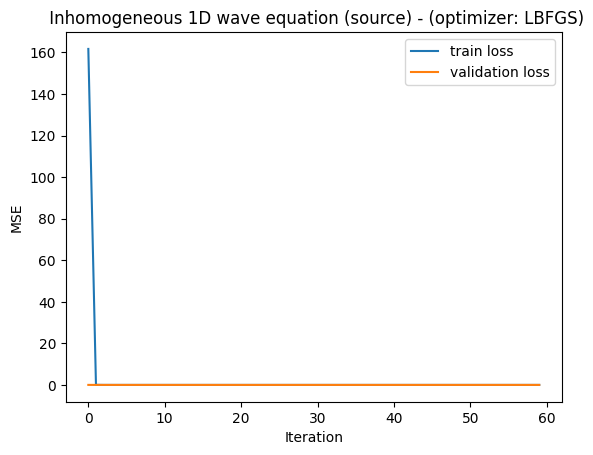

In [22]:
#plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title(" Inhomogeneous 1D wave equation (source) - (optimizer: LBFGS)")
plt.show()

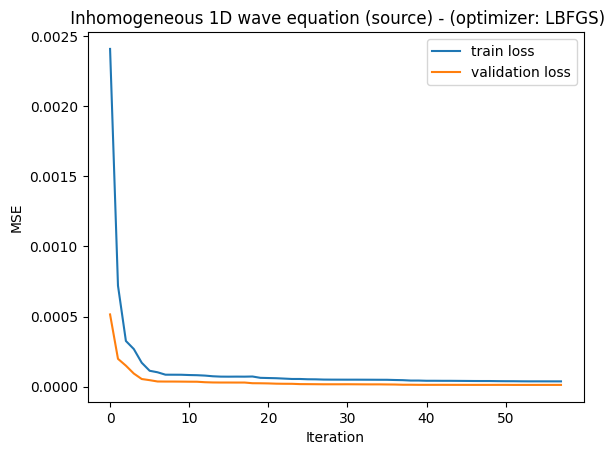

In [24]:
plt.plot(train_loss[2:], label='train loss')
plt.plot(val_loss[2:], label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title(" Inhomogeneous 1D wave equation (source) - (optimizer: LBFGS)")
plt.show()

In [ ]:
plt.figure(figsize=(30, 10))
plt.scatter(pinn.XT_c[:, 0], pinn.XT_c[:, 1])

# INFERENCE

In [44]:
# Load best model
print("Loading best model...")
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# Get test input data
XT_test = pinn.XT_test
x_test = pinn.XT_test[:, 0].flatten()
x_test.requires_grad = True
t_test = pinn.XT_test[:, 1].flatten()
t_test.requires_grad = True

# Calculate real solution
u_test_real = list()
for i in range(XT_test.shape[0]):
  x, t = XT_test[i, 0].cpu(), XT_test[i, 1].cpu()
  u = np.sin(2*np.pi*x) * (np.cos(4*t) + 2*np.sin(4*t)) - 2*np.sin(4*np.pi*x) * np.sin(8*t) + (np.pi/6)*x*(t**3)
  u_test_real.append(u)

u_test_real = np.array(u_test_real)

# Calculate PINN's solution and 1st derivative to check initial conditions
u_test_pinn = pinn.feed_forward.forward(torch.cat((x_test.view(-1, 1), t_test.view(-1, 1)), dim=1)).flatten()
u_test_pinn_t = torch.autograd.grad(u_test_pinn, t_test, grad_outputs=torch.ones_like(u_test_pinn), create_graph=True)[0]
u_test_pinn = u_test_pinn.detach().cpu().numpy().flatten()
u_test_pinn_t = u_test_pinn_t.detach().cpu().numpy().flatten()

# Calculate NMSE (Normalized Mean Square Error)
test_error = u_test_real - u_test_pinn
test_nmse = np.linalg.norm(u_test_real - u_test_pinn, 2) / np.linalg.norm(u_test_real, 2)
print(f'Test NMSE: {test_nmse}')

# Turn off 'requires_grad' and turn pytorch tensors into numpy arrays
x_test.requires_grad_ = False
x_test = x_test.detach().cpu().numpy().flatten()
t_test.requires_grad_ = False
t_test = t_test.detach().cpu().numpy().flatten()

test_df = pd.DataFrame(
    {
        't_test': t_test,
        'x_test': x_test,
        'u_test_real': u_test_real,
        'u_test_pinn': u_test_pinn
    }
)
test_df['abs_error'] = abs(test_df['u_test_real'] - test_df['u_test_pinn'])
test_df.to_csv('Inhomogeneous_wave_equation_results.csv', index=False)

Loading best model...
Test NMSE: 0.001330573228187859


In [45]:
test_df.head()

,t_test,x_test,u_test_real,u_test_pinn,abs_error
0,0.0,0.000000,0.000000,0.001215,0.001215
1,0.0,0.005025,0.031569,0.033032,0.001464
2,0.0,0.010050,0.063106,0.064707,0.001602
3,0.0,0.015075,0.094580,0.096218,0.001638
4,0.0,0.020101,0.125960,0.127573,0.001613


In [46]:
# df.sort_values(by='abs_error', ascending=False).head()

# PLOTS

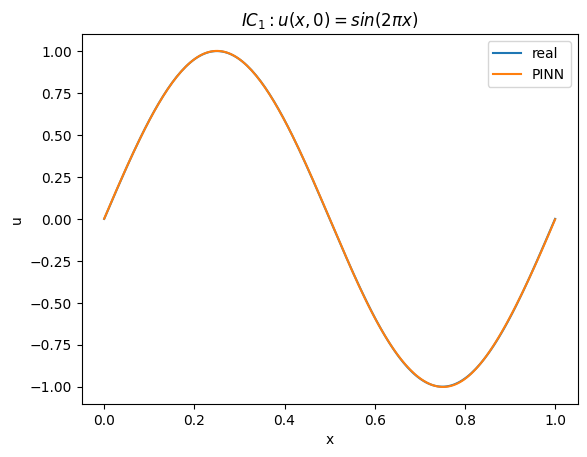

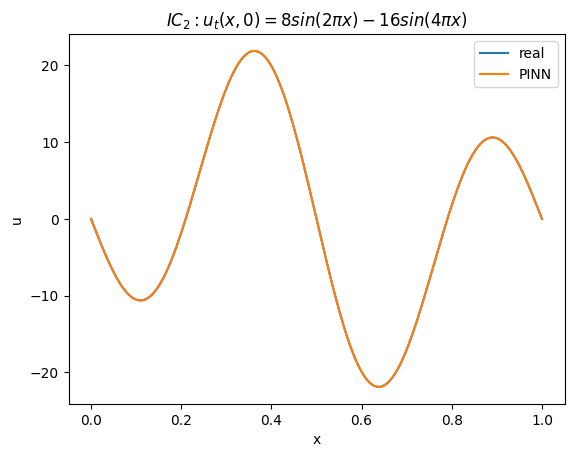

In [47]:
# Get x's where t=0
t0_df = test_df[test_df['t_test'] == 0.0]
x_t0 = t0_df['x_test'].to_numpy().flatten()

# *** Check 1st Initial Condition ***
u_t0_pinn = t0_df['u_test_pinn'].to_numpy()
u_t0_real = np.sin(2*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t0_real, label='real')
plt.plot(x_t0, u_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title(r"$IC_1: u(x, 0) = sin(2\pi x)$")
plt.legend()
plt.show()


# *** Check 2nd Initial Condition ***
pos_t0 = np.where(t_test == 0.0)
x_t0 = x_test[pos_t0]
t0 = t_test[pos_t0]
u_t_t0_pinn = u_test_pinn_t[pos_t0]
u_t_t0_real = 8*np.sin(2*np.pi*x_t0) - 16*np.sin(4*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t_t0_real, label='real')
plt.plot(x_t0, u_t_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title(r"$IC_2: u_t(x, 0) = 8sin(2\pi x) - 16sin(4\pi x)$")
plt.legend()
plt.show()

In [40]:
x_test = pinn.xc
t_test = pinn.tc

u_test_real_2D = u_test_real.reshape(len(x_test), len(t_test))
u_test_pinn_2D = u_test_pinn.reshape(len(x_test), len(t_test))
test_error_2D = test_error.reshape(len(x_test), len(t_test))

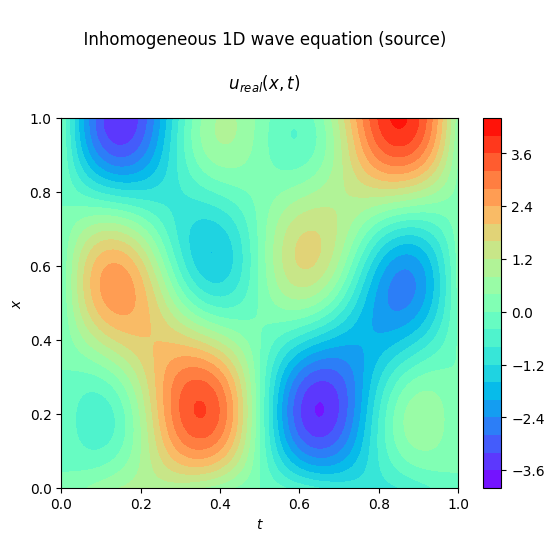

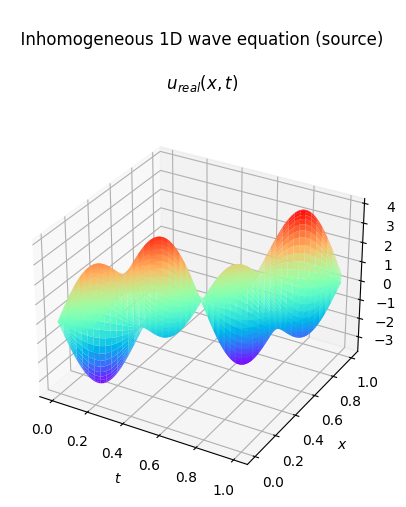

In [41]:
def plot_real(x,t,y):
  F_xt = y
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ u_{real}(x,t) $
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ u_{real}(x,t) $
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
#   ax.set_zlabel('f(x,t)')
  plt.show()


plot_real(x_test, t_test, u_test_real_2D)

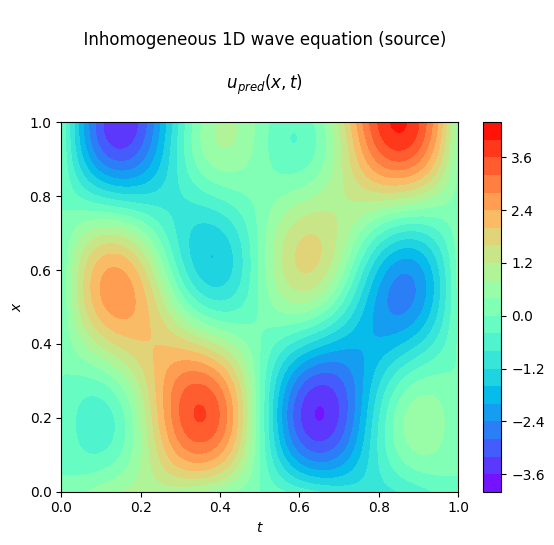

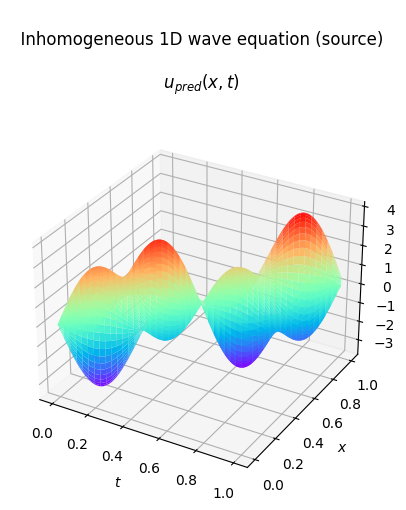

In [42]:
def plot_pred(x,t,y):
  F_xt = y
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ u_{pred}(x,t) $
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ u_{pred}(x,t) $
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
#   ax.set_zlabel('f(x,t)')
  plt.show()


plot_pred(x_test, t_test, u_test_pinn_2D)

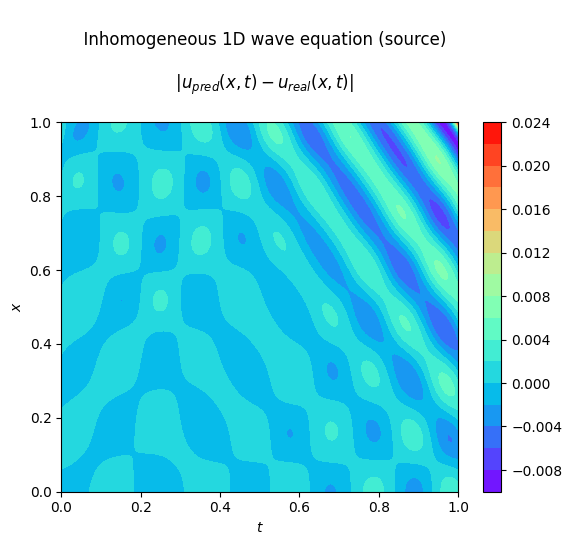

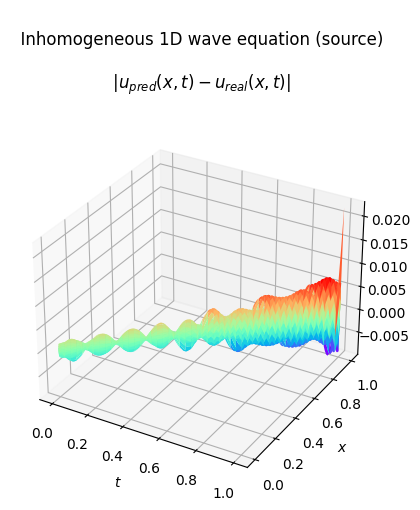

In [43]:
def plot_abs_diff(x,t,y):
  F_xt = y
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ |u_{pred}(x,t) - u_{real}(x,t)|$
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Inhomogeneous 1D wave equation (source)

  $ |u_{pred}(x,t) - u_{real}(x,t)|$
  ''')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$x$')
#   ax.set_zlabel('f(x,t)')
  plt.show()


plot_abs_diff(x_test, t_test, test_error_2D)